In [2]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np

In [230]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="SA"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_ds = xr.open_dataset(hr_path)
hr_ds

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 14600, bnds: 2, lon: 128, lat: 128)
Coordinates:
  * time       (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31...
  * lon        (lon) float32 512B 20.5 20.6 20.7 20.8 ... 32.9 33.0 33.1 33.2
  * lat        (lat) float32 512B -34.7 -34.6 -34.5 -34.4 ... -22.2 -22.1 -22.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 234kB ...
    lon_bnds   (lon, bnds) float32 1kB ...
    lat_bnds   (lat, bnds) float32 1kB ...
    crs        int32 4B ...
    pr         (time, lat, lon) float64 2GB ...
    tasmax     (time, lat, lon) float32 957MB ...
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Thu Sep 25 09:29:15 2025: cdo mergetime pr_tasmax_c...
    source:               CSIRO conformal-cubic model. Input file: ccam_8.km....
    Conventions:          CF-1.11
    title:                CCAM simulation data
    il:                   192
    ...                   ...
    ateb_ac_deltat:       1.0
    ateb_ac_heatcap:      10.0
    ateb_acfactor:        2.0
    ateb_alpha:           1.0
    ateb_lwintmeth:       2
    ateb_cvcoeffmeth:     1

In [231]:
lr_path = f'{DATA_PATH}/{folder}/{training_experiment}/predictors/{gcm_name}_{period_training}.nc'
lr_ds = xr.open_dataset(lr_path).astype("float32")
lr_ds

<xarray.Dataset> Size: 224MB
Dimensions:    (time: 14600, bnds: 2, lat: 16, lon: 16)
Coordinates:
  * time       (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31...
  * lon        (lon) float64 128B 11.0 13.0 15.0 17.0 ... 35.0 37.0 39.0 41.0
  * lat        (lat) float64 128B -40.0 -38.0 -36.0 -34.0 ... -14.0 -12.0 -10.0
Dimensions without coordinates: bnds
Data variables: (12/16)
    time_bnds  (time, bnds) float32 117kB -2.84e+17 -2.839e+17 ... 4.102e+18
    t_500      (time, lat, lon) float32 15MB 259.6 260.2 260.9 ... 273.8 273.9
    t_700      (time, lat, lon) float32 15MB 273.9 275.0 276.7 ... 288.7 288.9
    t_850      (time, lat, lon) float32 15MB 281.1 281.9 283.3 ... 295.2 295.6
    u_500      (time, lat, lon) float32 15MB 32.73 31.41 29.55 ... -2.396 -1.73
    u_700      (time, lat, lon) float32 15MB 17.41 18.26 18.15 ... -2.398 -2.568
    ...         ...
    z_500      (time, lat, lon) float32 15MB 5.658e+03 5.676e+03 ... 5.993e+03
    z_700      (time, lat, lon) float32 15MB 3.024e+03 3.033e+03 ... 3.214e+03
    z_850      (time, lat, lon) float32 15MB 1.443e+03 1.447e+03 ... 1.543e+03
    q_500      (time, lat, lon) float32 15MB 0.0007726 0.000761 ... 0.003252
    q_700      (time, lat, lon) float32 15MB 0.002427 0.00215 ... 0.00525
    q_850      (time, lat, lon) float32 15MB 0.005501 0.005668 ... 0.01188
Attributes: (12/259)
    CDI:                  Climate Data Interface version 1.9.8 (https://mpime...
    history:              Thu Sep 25 10:06:19 2025: cdo mergetime 2deg_ccam_a...
    source:               CSIRO conformal-cubic model. Input file: ccam_8.km....
    Conventions:          CF-1.11
    title:                CCAM simulation data
    il:                   192
    ...                   ...
    ateb_ac_deltat:       1.0
    ateb_ac_heatcap:      10.0
    ateb_acfactor:        2.0
    ateb_alpha:           1.0
    ateb_lwintmeth:       2
    ateb_cvcoeffmeth:     1

In [238]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
# Use all variables and locations from lr_ds as inputs
# Shape: (time, lat, lon, variable) -> flatten to (time, features)
features_da = lr_ds.to_array()  # dims: variable
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
X = features_da.values.reshape(features_da.sizes['time'], -1)

# Choose target variable and a single HR location (center by default)
target_var = 'tasmax'  # change to 'pr' if needed
if domain == "ALPS":
    y_idx = hr_ds.sizes['y'] // 2 + 1
    x_idx = hr_ds.sizes['x'] // 2 -10
    y_da = hr_ds[target_var].isel(y=y_idx, x=x_idx).sel(time=lr_ds.time)
else:
    y_idx = hr_ds.sizes['lat'] // 2 + 1
    x_idx = hr_ds.sizes['lon'] // 2 + 50    
    y_da = hr_ds[target_var].isel(lat=y_idx, lon=x_idx).sel(time=lr_ds.time)
y = np.sqrt(y_da.values)

# Remove times with any NaNs in features or target
mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Fit Ridge regression with standardization
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=200.0))
ridge_model.fit(X_clean, y_clean)

# Training score and predictions (optional)
alphas = np.logspace(1, 20, 20)
tscv = TimeSeriesSplit(n_splits=5)

pipeline = make_pipeline(StandardScaler(), Ridge())
param_grid = {'ridge__alpha': alphas}

gs = GridSearchCV(pipeline, param_grid, cv=tscv, scoring='r2', n_jobs=-1)
gs.fit(X_clean, y_clean)

ridge_model = gs.best_estimator_
print(f'Best alpha: {gs.best_params_["ridge__alpha"]}')

Best alpha: 1000.0


In [233]:
if 'time_bnds' in lr_ds.data_vars:
        lr_ds = lr_ds.drop_vars('time_bnds')

In [234]:
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Use all variables and locations from lr_ds as inputs
# Shape: (time, lat, lon, variable) -> flatten to (time, features)
features_da = lr_ds.to_array()  # dims: variable, time, lat, lon
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
X = features_da.values.reshape(features_da.sizes['time'], -1)

# Choose target variable and a single HR location (center by default)
target_var = 'pr'  # change to 'pr' if needed
y_idx = hr_ds.sizes['lat'] // 2
x_idx = hr_ds.sizes['lon'] // 2
y_da = hr_ds[target_var].isel(lat=y_idx, lon=x_idx).sel(time=lr_ds.time)
y = np.sqrt(y_da.values)

# Remove times with any NaNs in features or target
mask = np.isfinite(y) & np.all(np.isfinite(X), axis=1)
X_clean = X[mask]
y_clean = y[mask]

# Fit Ridge regression with standardization
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=100.0))
ridge_model.fit(X_clean, y_clean)

# Training score and predictions (optional)
ridge_r2 = ridge_model.score(X_clean, y_clean)
y_pred = ridge_model.predict(X_clean)
y_pred_da = xr.DataArray(y_pred, coords={'time': y_da.time.values[mask]}, dims=['time'], name=f'{target_var}_pred')
print(f'R^2 (train): {ridge_r2:.4f}')

R^2 (train): 0.5959


Train model only on past data

In [219]:
# Use all variables and locations from lr_ds as inputs
# Shape: (time, lat, lon, variable) -> flatten to (time, features)
features_da = lr_ds.to_array()  # dims: variable, time, lat, lon
features_da = features_da.transpose('time', 'lat', 'lon', 'variable')
X = features_da.values.reshape(features_da.sizes['time'], -1)

# Choose target variable and a single HR location (center by default)
target_var = 'pr'  # change to 'pr' if needed
y_idx = hr_ds.sizes['y'] // 2 - 10
x_idx = hr_ds.sizes['x'] // 2 + 20 
y_da = hr_ds[target_var].isel(y=y_idx, x=x_idx).sel(time=lr_ds.time)
y = np.sqrt(y_da.values)

# Remove times with any NaNs in features or target
maxpoint = len(X) // 2
X_clean = X[:maxpoint]
y_clean = y[:maxpoint]

# Fit Ridge regression with standardization
ridge_model = make_pipeline(StandardScaler(), Ridge(alpha=100.0))
ridge_model.fit(X_clean, y_clean)

# Training score and predictions (optional)
ridge_r2 = ridge_model.score(X_clean, y_clean)
y_pred = ridge_model.predict(X_clean)
y_pred_da = xr.DataArray(y_pred, coords={'time': y_da.time.values[:maxpoint]}, dims=['time'], name=f'{target_var}_pred')
print(f'R^2 (train): {ridge_r2:.4f}')

KeyError: 'y'

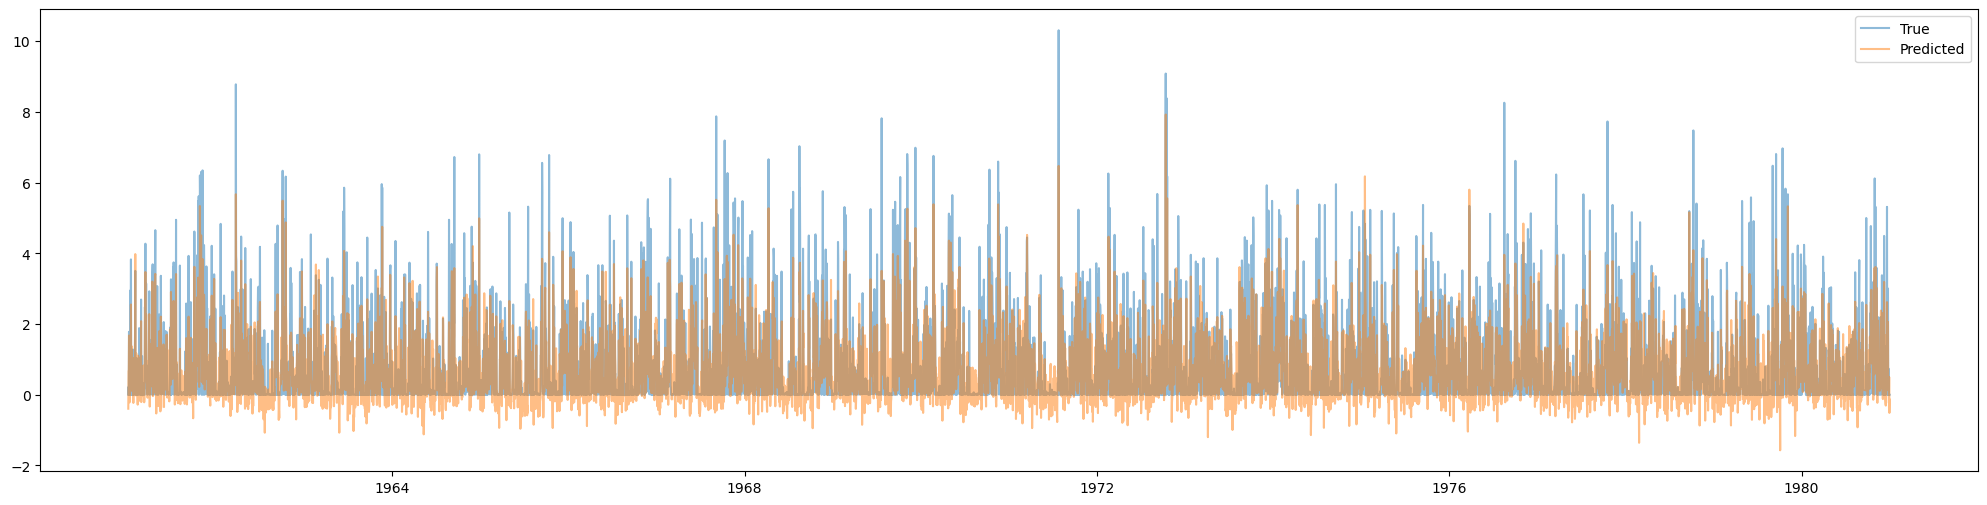

In [33]:
plt.figure(figsize=(25, 6))
plt.plot(y_da.time.values[:maxpoint], y[:maxpoint], label='True', alpha = 0.5)
plt.plot(y_pred_da.time.values, y_pred_da.values, label='Predicted', alpha = 0.5)
plt.legend();

Evaluate in future

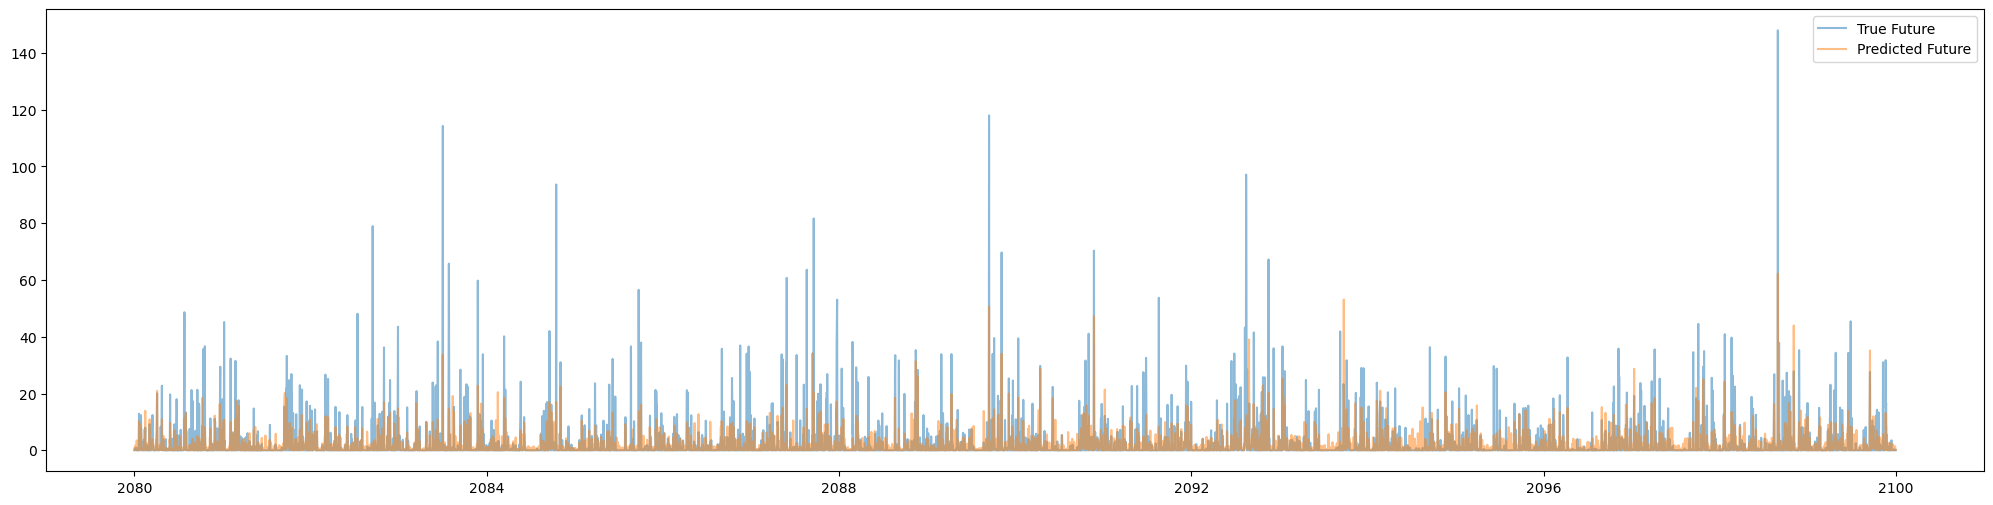

In [34]:
plt.figure(figsize=(25, 6))
pred_future = ridge_model.predict(X[maxpoint:])
pred_transformed = pred_future ** 2
plt.plot(y_da.time.values[maxpoint:], y_da.values[maxpoint:], label='True Future', alpha = 0.5)
plt.plot(y_da.time.values[maxpoint:], pred_transformed, label='Predicted Future', alpha = 0.5)
plt.legend();

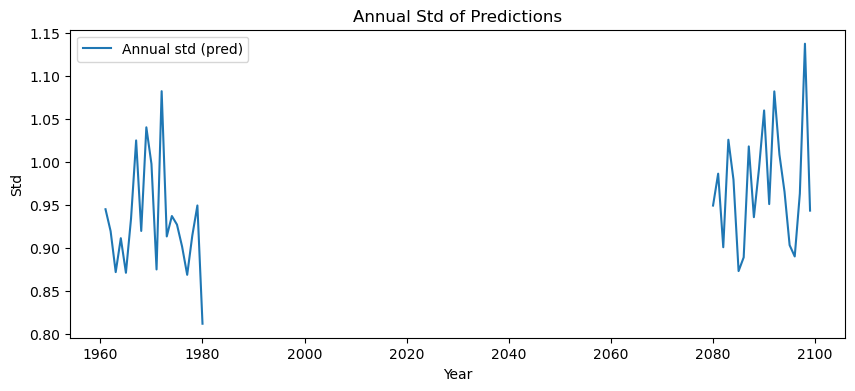

In [35]:
pred_full = np.concatenate([y_pred, pred_future])
pred_full_da = xr.DataArray(pred_full, coords={'time': y_da.time.values}, dims=['time'], name='pred')

annual_std = pred_full_da.resample(time='YS').std()

plt.figure(figsize=(10, 4))
plt.plot(annual_std.time.values, annual_std.values, label='Annual std (pred)')
plt.title('Annual Std of Predictions')
plt.xlabel('Year')
plt.ylabel('Std')
plt.legend();

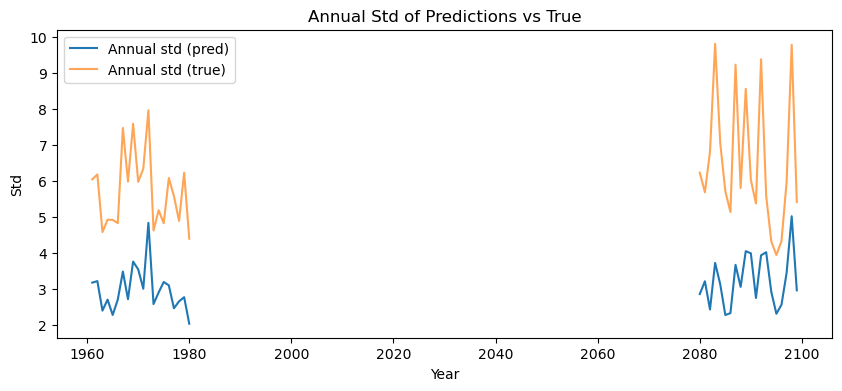

In [36]:
pred_full = np.concatenate([y_pred ** 2, pred_future ** 2])
pred_full_da = xr.DataArray(pred_full, coords={'time': y_da.time.values}, dims=['time'], name='pred')

annual_std_pred = pred_full_da.resample(time='YS').std()
annual_std_true = y_da.resample(time='YS').std()

plt.figure(figsize=(10, 4))
plt.plot(annual_std_pred.time.values, annual_std_pred.values, label='Annual std (pred)')
plt.plot(annual_std_true.time.values, annual_std_true.values, label='Annual std (true)', alpha=0.7)
plt.title('Annual Std of Predictions vs True')
plt.xlabel('Year')
plt.ylabel('Std')
plt.legend();

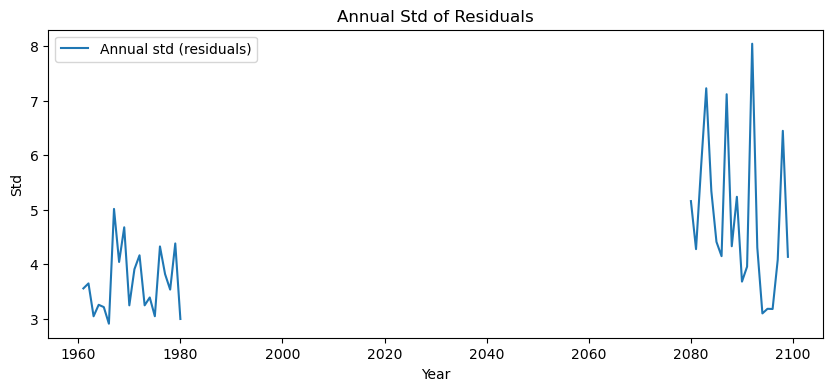

In [37]:
pred_full = np.concatenate([y_pred ** 2, pred_future ** 2])
pred_full_da = xr.DataArray(pred_full, coords={'time': y_da.time.values}, dims=['time'], name='pred')

annual_std_residuals = (y_da - pred_full_da).resample(time='YS').std()

plt.figure(figsize=(10, 4))
plt.plot(annual_std_residuals.time.values, annual_std_residuals.values, label='Annual std (residuals)')
plt.title('Annual Std of Residuals')
plt.xlabel('Year')
plt.ylabel('Std')
plt.legend();

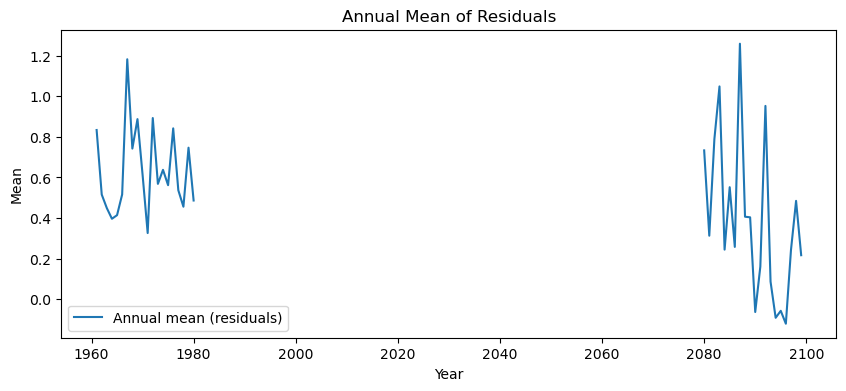

In [39]:
pred_full = np.concatenate([y_pred ** 2, pred_future ** 2])
pred_full_da = xr.DataArray(pred_full, coords={'time': y_da.time.values}, dims=['time'], name='pred')

annual_mean_residuals = (y_da - pred_full_da).resample(time='YS').mean()

plt.figure(figsize=(10, 4))
plt.plot(annual_mean_residuals.time.values, annual_mean_residuals.values, label='Annual mean (residuals)')
plt.title('Annual Mean of Residuals')
plt.xlabel('Year')
plt.ylabel('Mean')
plt.legend();

In [ ]:

plt.plot(y_da.time.values[maxpoint:], y[maxpoint:], label='True Future', alpha = 0.5)
plt.plot(y_da.time.values[maxpoint:], pred_future, label='Predicted Future', alpha = 0.5)

In [45]:
# Fit a separate Ridge model for multiple HR locations and save predictions (past + future)

# Select a subset of locations to reduce compute (adjust step_y/step_x as needed)
step_y, step_x = 4, 4
y_indices = np.arange(0, hr_ds.sizes['y'], step_y)
x_indices = np.arange(0, hr_ds.sizes['x'], step_x)

# Prepare output arrays
preds = xr.DataArray(
    np.empty((lr_ds.sizes['time'], len(y_indices), len(x_indices)), dtype=np.float32),
    coords={'time': lr_ds.time, 'y': hr_ds.y.values[y_indices], 'x': hr_ds.x.values[x_indices]},
    dims=['time', 'y', 'x'],
    name=f'{target_var}_ridge_pred',
    attrs={'units': hr_ds[target_var].attrs.get('units', '')}
)
r2_past = xr.DataArray(
    np.empty((len(y_indices), len(x_indices)), dtype=np.float32),
    coords={'y': hr_ds.y.values[y_indices], 'x': hr_ds.x.values[x_indices]},
    dims=['y', 'x'],
    name=f'{target_var}_ridge_r2_past'
)
r2_future = xr.DataArray(
    np.empty((len(y_indices), len(x_indices)), dtype=np.float32),
    coords={'y': hr_ds.y.values[y_indices], 'x': hr_ds.x.values[x_indices]},
    dims=['y', 'x'],
    name=f'{target_var}_ridge_r2_future'
)

# Use the alpha from the existing pipeline if available, else fallback
alpha_val = 70.0
try:
    alpha_val = ridge_model.named_steps['ridge'].alpha
except Exception:
    pass

# Train per-location on past data, predict past + future
for yi_i, yi in enumerate(y_indices):
    for xi_i, xi in enumerate(x_indices):
        y_loc_da = hr_ds[target_var].isel(y=yi, x=xi).sel(time=lr_ds.time)
        y_loc = y_loc_da.values

        X_train = X[:maxpoint]
        y_train = y_loc[:maxpoint]

        model = make_pipeline(StandardScaler(), Ridge(alpha=alpha_val))
        model.fit(X_train, y_train)

        preds.values[:maxpoint, yi_i, xi_i] = model.predict(X[:maxpoint]).astype(np.float32)
        preds.values[maxpoint:, yi_i, xi_i] = model.predict(X[maxpoint:]).astype(np.float32)

        r2_past.values[yi_i, xi_i] = model.score(X_train, y_train)
        r2_future.values[yi_i, xi_i] = model.score(X[maxpoint:], y_loc[maxpoint:])

# preds contains predictions for all selected locations across full time
# r2_past and r2_future contain scores per location

KeyboardInterrupt: 

In [38]:
maxpoint

7305

In [39]:
preds

<xarray.DataArray 'tasmax_ridge_pred' (time: 14610, y: 16, x: 16)> Size: 15MB
array([[[288.2062 , 289.07303, 287.36905, ..., 287.4008 , 287.39252,
         287.1709 ],
        [289.4645 , 289.17172, 289.1651 , ..., 287.05807, 286.98563,
         286.9209 ],
        [288.90634, 288.6495 , 288.67035, ..., 286.6315 , 286.86792,
         286.84845],
        ...,
        [280.25095, 279.846  , 280.24252, ..., 274.4534 , 271.0116 ,
         269.93512],
        [279.9231 , 279.82187, 279.55872, ..., 273.21402, 270.02942,
         269.2162 ],
        [281.3333 , 279.45883, 278.5643 , ..., 273.62494, 274.6088 ,
         274.2695 ]],

       [[283.48367, 284.07172, 283.71368, ..., 288.83743, 288.81122,
         288.83023],
        [287.60004, 287.548  , 287.60406, ..., 288.10437, 288.2887 ,
         288.4643 ],
        [286.98517, 287.1487 , 287.3549 , ..., 286.4973 , 288.00793,
         288.22018],
...
        [286.68893, 285.4049 , 285.10364, ..., 280.56924, 279.8234 ,
         279.32767],
        [285.74515, 285.29572, 284.68704, ..., 279.48486, 278.3727 ,
         280.56894],
        [286.2601 , 284.82904, 284.01883, ..., 281.79382, 282.83017,
         282.57214]],

       [[289.40054, 290.94366, 289.67493, ..., 291.84595, 291.6571 ,
         291.31992],
        [291.00314, 290.7404 , 290.97656, ..., 291.81805, 291.42517,
         291.07758],
        [290.92374, 290.71942, 290.73395, ..., 292.28174, 291.21362,
         291.3857 ],
        ...,
        [285.7644 , 284.73758, 283.87704, ..., 280.08633, 277.94058,
         277.30835],
        [284.3825 , 283.67093, 282.73218, ..., 278.45703, 276.21213,
         278.61133],
        [285.2567 , 282.43958, 281.32834, ..., 280.07327, 280.52133,
         281.36774]]], shape=(14610, 16, 16), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * y        (y) float64 128B 1.412e+03 1.512e+03 ... 2.812e+03 2.912e+03
  * x        (x) float64 128B 2.062e+03 2.162e+03 ... 3.462e+03 3.562e+03
Attributes:
    units:    K

Get warming trend

In [42]:
# Create a full-sized prediction array (time, y, x) and insert preds at sampled locations
full_preds = xr.DataArray(
    np.full((lr_ds.sizes['time'], hr_ds.sizes['y'], hr_ds.sizes['x']), np.nan, dtype=np.float32),
    coords={'time': lr_ds.time, 'y': hr_ds.y, 'x': hr_ds.x},
    dims=['time', 'y', 'x'],
    name=preds.name,
    attrs=preds.attrs,
)

iy, ix = np.ix_(y_indices, x_indices)
full_preds.values[:, iy, ix] = preds.values
full_preds

<xarray.DataArray 'tasmax_ridge_pred' (time: 14610, y: 128, x: 128)> Size: 957MB
array([[[288.2062 ,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[283.48367,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
...
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]],

       [[289.40054,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        ...,
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan],
        [      nan,       nan,       nan, ...,       nan,       nan,
               nan]]], shape=(14610, 128, 128), dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 2099-12-31T1...
  * y        (y) float64 1kB 1.412e+03 1.425e+03 1.438e+03 ... 2.988e+03 3e+03
  * x        (x) float64 1kB 2.062e+03 2.075e+03 ... 3.638e+03 3.65e+03
Attributes:
    units:    K

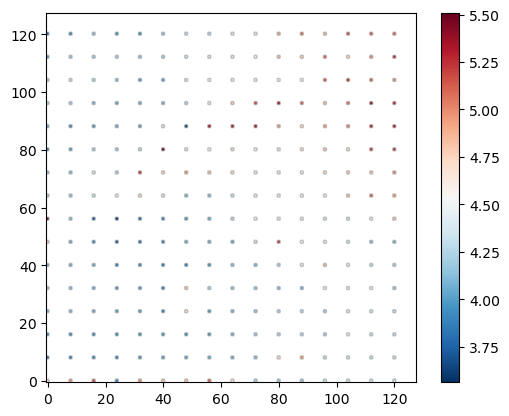

In [44]:
plt.imshow(full_preds.values[maxpoint:].mean(axis=0) - full_preds.values[:maxpoint].mean(axis=0), cmap="RdBu_r", origin="lower");
plt.colorbar()

### Get from pre computed

Only needed if preds on disk don't include all locations.

        full_preds = xr.DataArray(
            np.full((lr_ds.sizes['time'], hr_ds.sizes['y'], hr_ds.sizes['x']), np.nan, dtype=np.float32),
            coords={'time': lr_ds.time, 'y': hr_ds.y, 'x': hr_ds.x},
            dims=['time', 'y', 'x'],
            attrs=preds_from_disk.attrs,
        )
        step_y, step_x = 1, 1
        y_indices = np.arange(0, hr_ds.sizes['y'], step_y)
        x_indices = np.arange(0, hr_ds.sizes['x'], step_x)
        iy, ix = np.ix_(y_indices, x_indices)
        full_preds.values[:, iy, ix] = preds_from_disk["tasmax_ridge_pred"].values
        full_preds

In [1]:
import torch 
import xarray as xr
import os
import matplotlib.pyplot as plt
import numpy as np

In [181]:
root="/r/scratch/users/mschillinger/data/cordexbench/"
domain="SA"
training_experiment = 'Emulator_hist_future'
mode = "train" 
if mode == "train":
    folder = "train"
else:
    raise ValueError("In DownscalingDatasetNormed: mode not recognised")
        
if training_experiment == 'ESD_pseudo_reality':
    period_training = '1961-1980'
elif training_experiment == 'Emulator_hist_future':
    period_training = '1961-1980_2080-2099'
else:
    raise ValueError('Provide a valid date')

# Set the GCM
if domain == 'ALPS':
    gcm_name = 'CNRM-CM5'
elif domain == 'NZ' or domain == 'SA':
    gcm_name = 'ACCESS-CM2'
DATA_PATH = root + f"/{domain}/{domain}_domain"
hr_path = f'{DATA_PATH}/{folder}/{training_experiment}/target/pr_tasmax_{gcm_name}_{period_training}.nc'
hr_ds = xr.open_dataset(hr_path)

target_var = "tasmax"

In [182]:
if target_var == "tasmax" and domain == "ALPS":
    output_path = f'{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-100.0_preds_20260210-165713.nc'
else:
    output_path = f'{DATA_PATH}/{folder}/{training_experiment}/linear_models/ridge_{target_var}_{gcm_name}_{period_training}_alpha-100.0_preds.nc'
#  /r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_preds_20260204-180954.nc
# /r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_preds.nc
preds_from_disk = xr.open_dataset(output_path)  # check if file exists

In [183]:
preds_from_disk

<xarray.Dataset> Size: 957MB
Dimensions:            (time: 14600, y: 128, x: 128)
Coordinates:
  * time               (time) datetime64[ns] 117kB 1961-01-01T12:00:00 ... 20...
  * y                  (y) float32 512B -34.7 -34.6 -34.5 ... -22.2 -22.1 -22.0
  * x                  (x) float32 512B 20.5 20.6 20.7 20.8 ... 33.0 33.1 33.2
Data variables:
    tasmax_ridge_pred  (time, y, x) float32 957MB ...

In [184]:
preds_from_disk[f"{target_var}_ridge_pred"].values

array([[[297.45483, 297.5005 , 297.52863, ..., 296.4553 , 296.27945,
         296.12396],
        [297.76474, 297.8647 , 297.83722, ..., 296.58627, 296.43173,
         296.2632 ],
        [304.44962, 298.0996 , 298.3904 , ..., 296.7303 , 296.5615 ,
         296.39374],
        ...,
        [299.96228, 299.89047, 300.0864 , ..., 305.70462, 305.59338,
         305.5429 ],
        [299.94437, 299.94058, 299.9318 , ..., 305.53806, 305.64035,
         305.6425 ],
        [299.79453, 299.626  , 299.92807, ..., 305.44067, 305.5691 ,
         305.449  ]],

       [[294.9864 , 295.02136, 295.08472, ..., 296.32755, 296.18594,
         296.05124],
        [295.01135, 295.0883 , 295.13693, ..., 296.44696, 296.31232,
         296.17255],
        [300.1694 , 295.0808 , 295.17178, ..., 296.57568, 296.3979 ,
         296.24677],
        ...,
        [302.82806, 302.909  , 302.8298 , ..., 307.18643, 306.99286,
         307.23517],
        [302.36392, 302.64636, 302.7204 , ..., 307.24277, 307.28366,
   

In [185]:
maxpoint = len(preds_from_disk.time) // 2

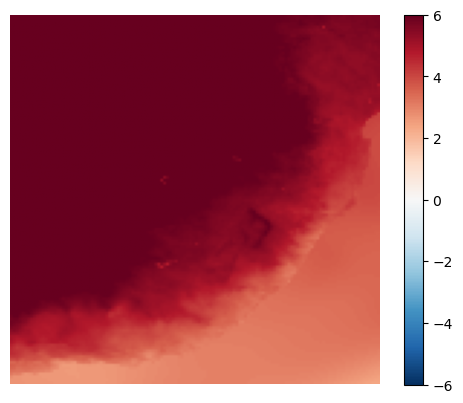

In [186]:
plt.imshow(preds_from_disk[f"{target_var}_ridge_pred"].values[maxpoint:].mean(axis=0) - preds_from_disk[f"{target_var}_ridge_pred"].values[:maxpoint].mean(axis=0), 
           cmap="RdBu_r", origin="lower", vmin=-6, vmax=6);
plt.axis("off");
plt.colorbar();

In [187]:
full_preds = preds_from_disk[f"{target_var}_ridge_pred"]

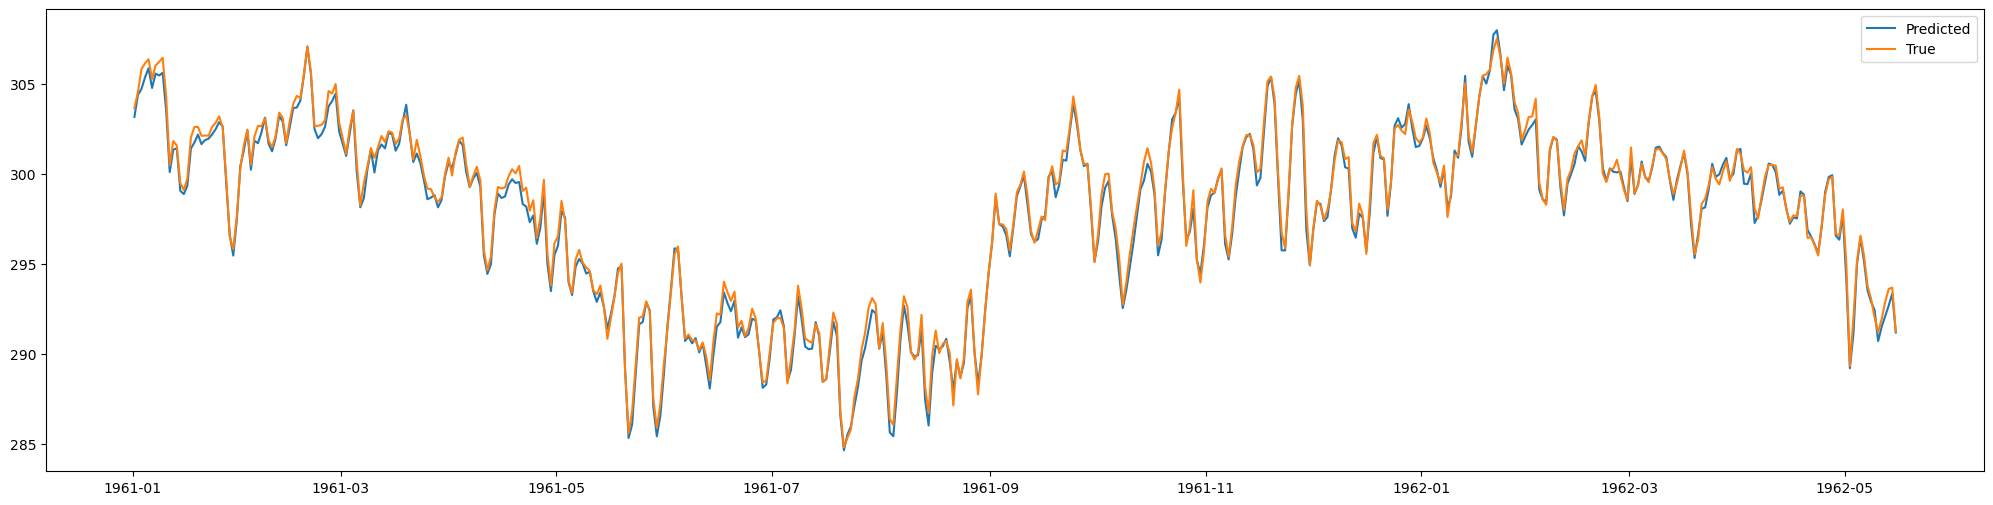

In [188]:
plt.figure(figsize=(25, 6))
plt.plot(full_preds.time.values[:500], full_preds.values.mean(axis=(1,2))[:500], label='Predicted')
plt.plot(hr_ds.time.values[:500], hr_ds[target_var].values.mean(axis=(1,2))[:500], label='True')
plt.legend();

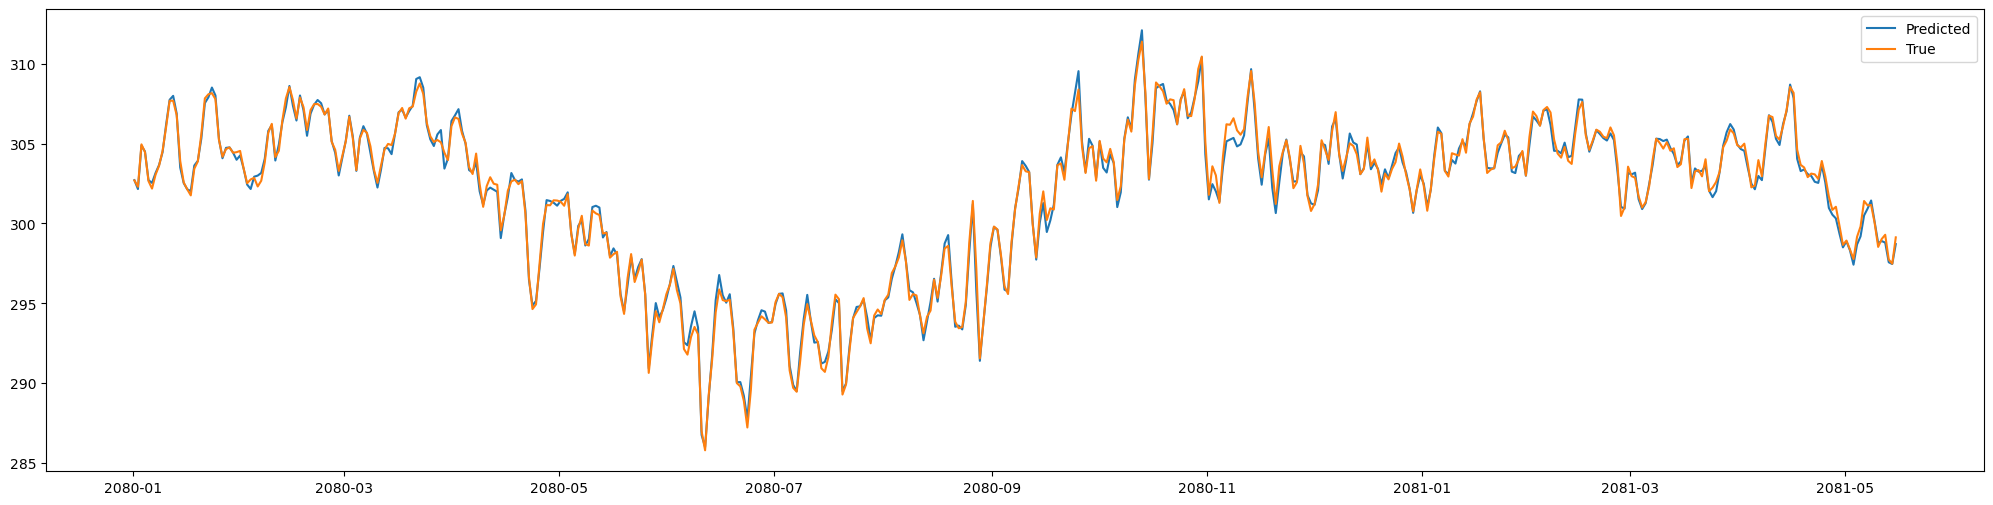

In [189]:
plt.figure(figsize=(25, 6))
plt.plot(full_preds.time.values[maxpoint:(maxpoint+500)], full_preds.values.mean(axis=(1,2))[maxpoint:(maxpoint+500)], label='Predicted')
plt.plot(hr_ds.time.values[maxpoint:(maxpoint+500)], hr_ds[target_var].values.mean(axis=(1,2))[maxpoint:(maxpoint+500)], label='True')
plt.legend();

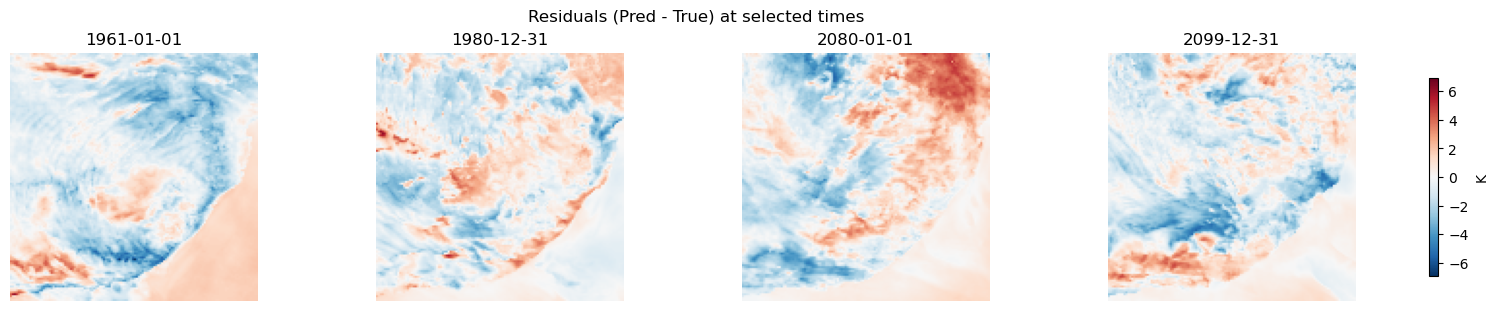

In [190]:
# Plot spatial residuals (pred - true) for a few time points

# pick a few representative indices: start, last past day, first future day, end
idxs = [0, maxpoint - 1, maxpoint, full_preds.sizes['time'] - 1]

# compute residuals for selected times
hr_da = hr_ds[target_var]
if {'lat', 'lon'}.issubset(hr_da.dims):
    hr_da = hr_da.rename({'lat': 'y', 'lon': 'x'})
residuals = [(i, (full_preds.isel(time=i) - hr_da.isel(time=i))) for i in idxs]

# symmetric color scale based on max absolute residual across selected times
v = max(float(np.nanmax(np.abs(r.values))) for _, r in residuals)

fig, axes = plt.subplots(1, len(residuals), figsize=(4 * len(residuals), 3), constrained_layout=True)
if len(residuals) == 1:
    axes = [axes]

for ax, (i, r) in zip(axes, residuals):
    im = ax.imshow(r.values, origin='lower', cmap='RdBu_r', vmin=-v, vmax=v)
    ts = str(full_preds.time.values[i])[:10]
    ax.set_title(f'{ts}')
    ax.axis('off')

fig.suptitle('Residuals (Pred - True) at selected times')
fig.colorbar(im, ax=axes, shrink=0.8, label='K')

In [193]:
preds_pt = torch.load(
    # "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt"
    # hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_CNRM-CM5_1961-1980_2080-2099_sqrt.pt
    # hr_norm_stats_linear-pred_all_ESD_pseudo_reality_pr_CNRM-CM5_1961-1980_sqrt.pt
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_{training_experiment}_{target_var}_{gcm_name}_{period_training}.pt"
)

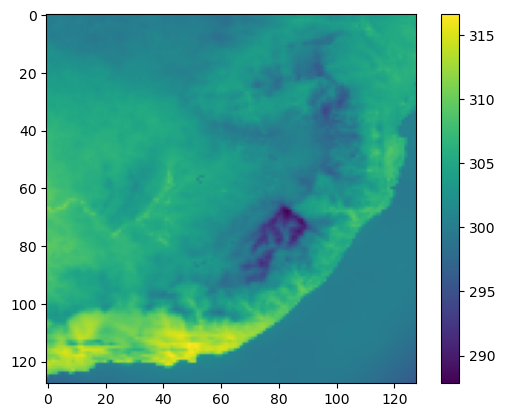

In [194]:
plt.imshow(preds_pt["pred"][0].numpy())
plt.colorbar();

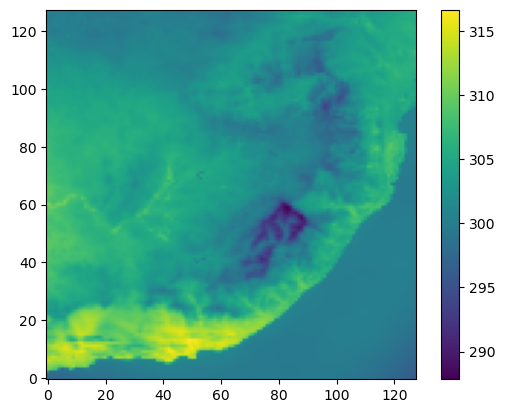

In [195]:
plt.imshow(full_preds[0].values, origin="lower");
plt.colorbar();

In [180]:
np.flip(full_preds.values, axis=1) - preds_pt["pred"].numpy()

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

Correct wrong _sqrt

preds_pt = torch.load(
    # "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt"
    # hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_CNRM-CM5_1961-1980_2080-2099_sqrt.pt
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_{gcm_name}_1961-1980_2080-2099_sqrt.pt"
)

torch.save(preds_pt, 
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_{gcm_name}_1961-1980_2080-2099.pt")

torch.save({
    "pred": torch.sqrt(preds_pt["pred"])
    }, 
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_{gcm_name}_1961-1980_2080-2099_sqrt.pt")

preds_pt = torch.load(
    # "/r/scratch/users/mschillinger/data/cordexbench/ALPS/norm_stats/hr_norm_stats_linear-pred_all_Emulator_hist_future_tasmax_CNRM-CM5_1961-1980_2080-2099.pt"
    # hr_norm_stats_linear-pred_all_Emulator_hist_future_pr_CNRM-CM5_1961-1980_2080-2099_sqrt.pt
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_ESD_pseudo_reality_pr_{gcm_name}_1961-1980_sqrt.pt"
)

torch.save(preds_pt, 
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_ESD_pseudo_reality_pr_{gcm_name}_1961-1980.pt")

torch.save({
    "pred": torch.sqrt(preds_pt["pred"])
    }, 
    f"/r/scratch/users/mschillinger/data/cordexbench/{domain}/norm_stats/hr_norm_stats_linear-pred_all_ESD_pseudo_reality_pr_{gcm_name}_1961-1980_sqrt.pt")

# Linear model coef check

In [1]:
import os

In [2]:
folder = "/r/scratch/users/mschillinger/data/cordexbench//ALPS/ALPS_domain/train/Emulator_hist_future/linear_models/"

os.listdir(folder)

['ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_preds_20260210-165713.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_preds.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_coefs.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_infer_20260210-150419.nc',
 'ridge_pr_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_perloc_scaler.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_intercepts_20260210-165717.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_intercepts.nc',
 'trained_on_past',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_coefs_20260210-165716.nc',
 'ridge_pr_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_coefs.nc',
 'ridge_pr_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_preds.nc',
 'ridge_pr_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_intercepts.nc',
 'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_perloc_scaler.nc']

In [ ]:
'ridge_tasmax_CNRM-CM5_1961-1980_2080-2099_alpha-100.0_coefs.nc